# Validating fine-tuned Generator via fine-tuned Classifier

In [11]:
# setup 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pprint
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset, concatenate_datasets


# load data
generated_speeches_df = pd.read_csv("../data/generated_speeches_final_context.csv")



In [12]:
# seperate dfs per model answers

all_columns_to_predict = ['speech_base_model_01', 
                          'speech_ft_model_01',
                          'speech_base_model_03', 
                          'speech_ft_model_03', 
                          'RAG_speech_01',
                          'RAG_01_context_1', 
                          'RAG_01_context_2', 
                          'RAG_01_context_3',
                          'RAG_speech_03']


data_dict = {}

for column in all_columns_to_predict:
    df = generated_speeches_df[["party", column]].rename(columns={"party": "label", column: "speech_text"})
    data_dict[column] = Dataset.from_pandas(df)

# save single dfs:
speech_base_model_01 = data_dict["speech_base_model_01"]
speech_ft_model_01 = data_dict["speech_ft_model_01"]
speech_base_model_03 = data_dict["speech_base_model_03"]
speech_ft_model_03 = data_dict["speech_ft_model_03"]
RAG_speech_01 = data_dict["RAG_speech_01"]
RAG_01_context_1 = data_dict["RAG_01_context_1"]
RAG_01_context_2 = data_dict["RAG_01_context_2"]
RAG_01_context_3 = data_dict["RAG_01_context_3"]
RAG_speech_03 = data_dict["RAG_speech_03"]


# merging the original speech data into one baseline df
baseline_real_speeches = concatenate_datasets([RAG_01_context_1, RAG_01_context_2, RAG_01_context_3])

In [13]:
# load best classifier model

# for now second best

# Load model and tokenizer from local folder
model = AutoModelForSequenceClassification.from_pretrained("../data/allresultsA/")
tokenizer = AutoTokenizer.from_pretrained("../data/allresultsA/")


In [14]:
# define parameters
WINDOW_LENGTH = 512
STRIDE = 256


label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']
#label2id = {label: i for i, label in enumerate(sorted(label_names))}
#id2label = {i: label for label, i in label2id.items()}

In [15]:
# model und tokenizer müssen schon geladen sein
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"]  # falls du wahren Wert mitgeben willst
        })

    for item in results:
      probs = item["probs"]
      pred_idx = int(np.argmax(probs))
      item["prediction_label"] = label_names[pred_idx]
    return results


In [34]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



In [24]:
all_models_to_test = [speech_base_model_01, 
                          speech_ft_model_01,
                          speech_base_model_03, 
                          speech_ft_model_03, 
                          RAG_speech_01,
                          RAG_speech_03,
                          baseline_real_speeches]

model_names = ['speech_base_model_01', 
                          'speech_ft_model_01',
                          'speech_base_model_03', 
                          'speech_ft_model_03', 
                          'RAG_speech_01',
                          'RAG_speech_03',
                          'baseline_real_speeches']


all_results = {}
i = 0
for dataset_to_predict in all_models_to_test:
    all_results[model_names[i]] = predict_proba_for_dataset(dataset_to_predict, sorted(label_names))
    i += 1



100%|██████████| 72/72 [02:18<00:00,  1.93s/it]


/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: speech_base_model_01
  Accuracy: 0.08333333333333333
  Balanced Accuracy: 0.08333333333333333
  Precision: 0.044444444444444446
  Recall: 0.07142857142857142
  F1-score: 0.05372405372405372
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.00      0.00      0.00         4
     CDU/CSU       0.00      0.00      0.00         0
         FDP       0.20      0.25      0.22         4
       GRÜNE       0.11      0.25      0.15         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4
       Union       0.00      0.00      0.00         4

    accuracy                           0.08        24
   macro avg       0.04      0.07      0.05        24
weighted avg       0.05      0.08      0.06        24



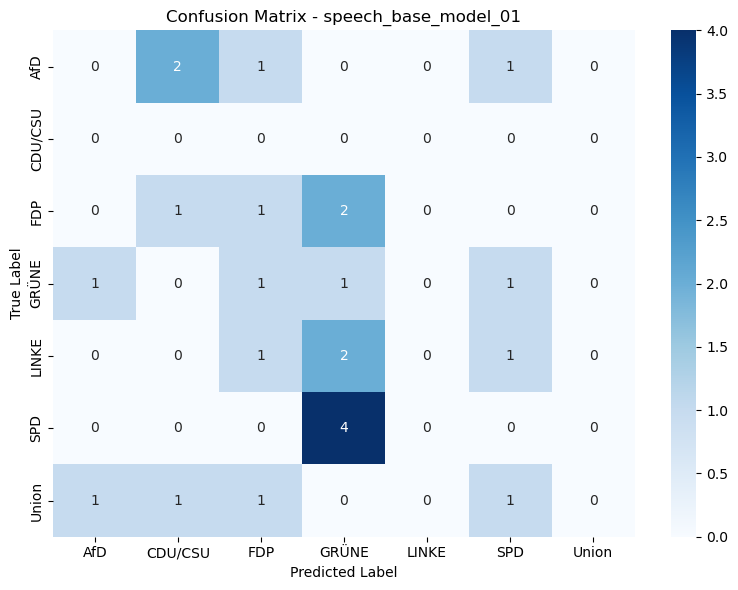

Model: speech_ft_model_01
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.1765873015873016
  Recall: 0.20833333333333334
  F1-score: 0.17474747474747473
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.25      0.50      0.33         4
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.14      0.25      0.18         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.17      0.25      0.20         4
       Union       0.00      0.00      0.00         4

    accuracy                           0.21        24
   macro avg       0.18      0.21      0.17        24
weighted avg       0.18      0.21      0.17        24



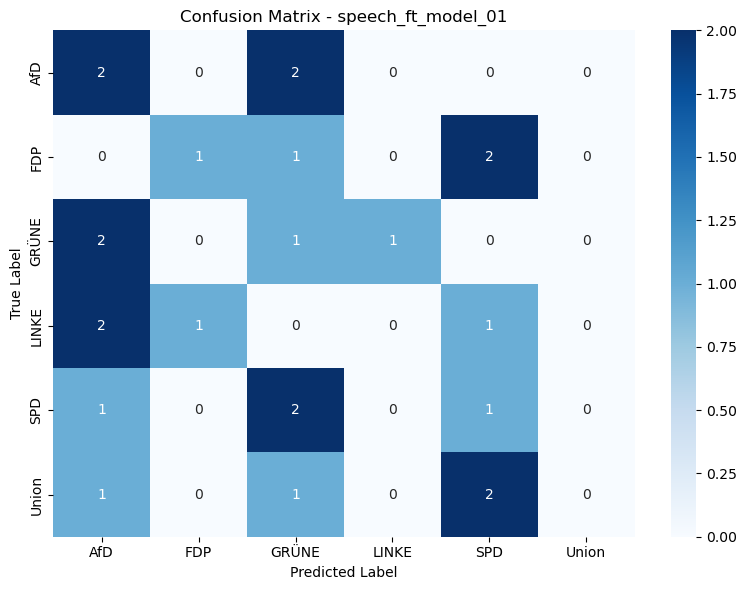

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: speech_base_model_03
  Accuracy: 0.16666666666666666
  Balanced Accuracy: 0.16666666666666666
  Precision: 0.2346938775510204
  Recall: 0.14285714285714285
  F1-score: 0.13650793650793652
  Classification Report:
              precision    recall  f1-score   support

         AfD       1.00      0.25      0.40         4
     CDU/CSU       0.00      0.00      0.00         0
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.14      0.50      0.22         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4
       Union       0.00      0.00      0.00         4

    accuracy                           0.17        24
   macro avg       0.23      0.14      0.14        24
weighted avg       0.27      0.17      0.16        24



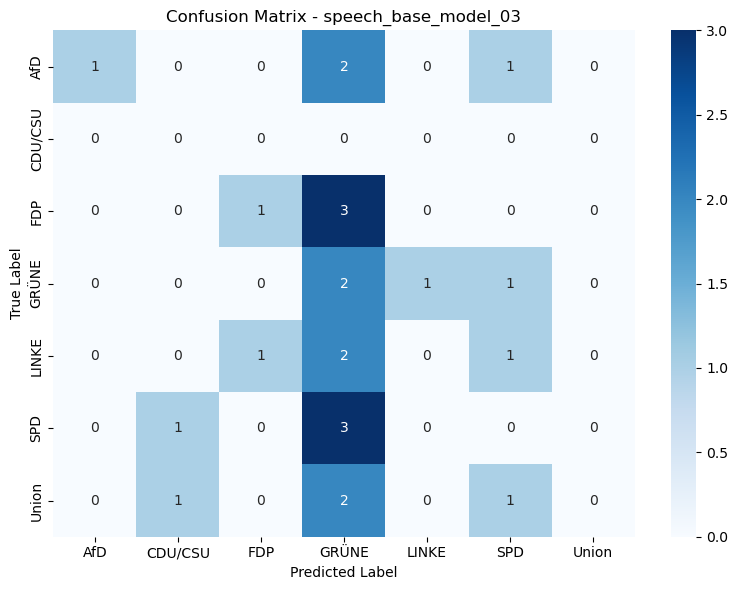

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: speech_ft_model_03
  Accuracy: 0.16666666666666666
  Balanced Accuracy: 0.16666666666666666
  Precision: 0.0695970695970696
  Recall: 0.14285714285714285
  F1-score: 0.0907563025210084
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.33      0.50      0.40         4
     CDU/CSU       0.00      0.00      0.00         0
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.15      0.50      0.24         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4
       Union       0.00      0.00      0.00         4

    accuracy                           0.17        24
   macro avg       0.07      0.14      0.09        24
weighted avg       0.08      0.17      0.11        24



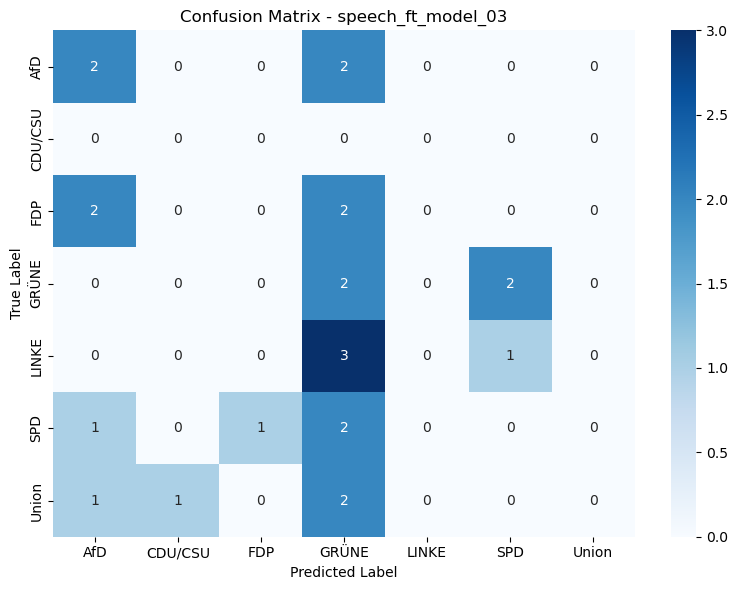

Model: RAG_speech_01
  Accuracy: 0.08333333333333333
  Balanced Accuracy: 0.08333333333333333
  Precision: 0.03333333333333333
  Recall: 0.08333333333333333
  F1-score: 0.04761904761904762
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.00      0.00      0.00         4
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.20      0.50      0.29         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4
       Union       0.00      0.00      0.00         4

    accuracy                           0.08        24
   macro avg       0.03      0.08      0.05        24
weighted avg       0.03      0.08      0.05        24



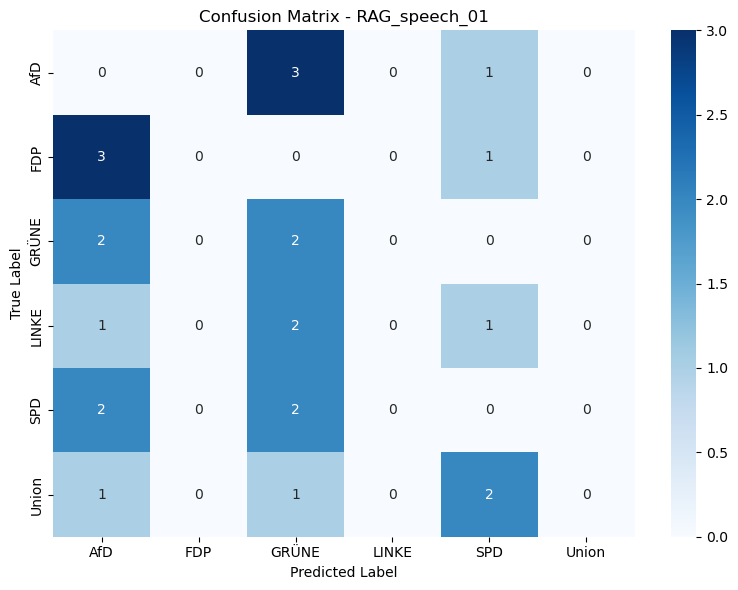

Model: RAG_speech_03
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.10277777777777779
  Recall: 0.20833333333333334
  F1-score: 0.1365079365079365
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.25      0.50      0.33         4
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.20      0.50      0.29         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.17      0.25      0.20         4
       Union       0.00      0.00      0.00         4

    accuracy                           0.21        24
   macro avg       0.10      0.21      0.14        24
weighted avg       0.10      0.21      0.14        24



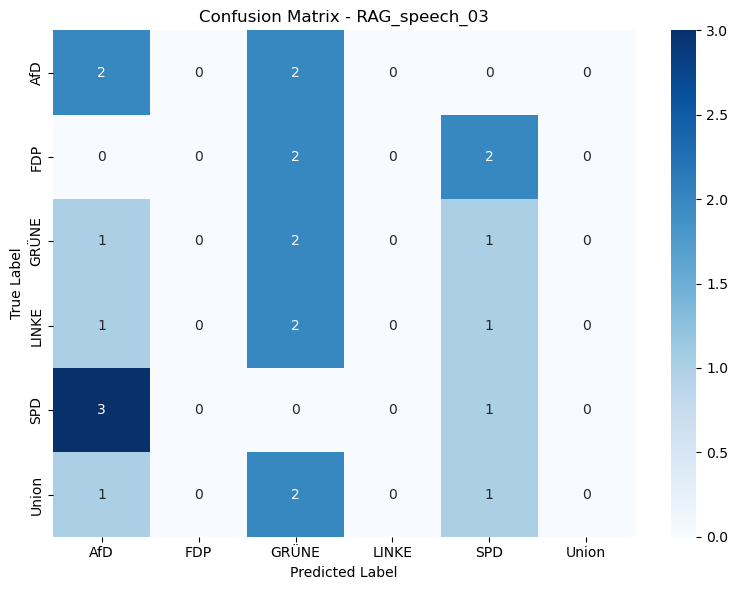

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: baseline_real_speeches
  Accuracy: 0.5555555555555556
  Balanced Accuracy: 0.5555555555555556
  Precision: 0.5295787545787546
  Recall: 0.4761904761904762
  F1-score: 0.4932838589981448
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.80      0.67      0.73        12
     CDU/CSU       0.00      0.00      0.00         0
         FDP       1.00      0.67      0.80        12
       GRÜNE       0.62      0.67      0.64        12
       LINKE       0.67      0.50      0.57        12
         SPD       0.62      0.83      0.71        12
       Union       0.00      0.00      0.00        12

    accuracy                           0.56        72
   macro avg       0.53      0.48      0.49        72
weighted avg       0.62      0.56      0.58        72



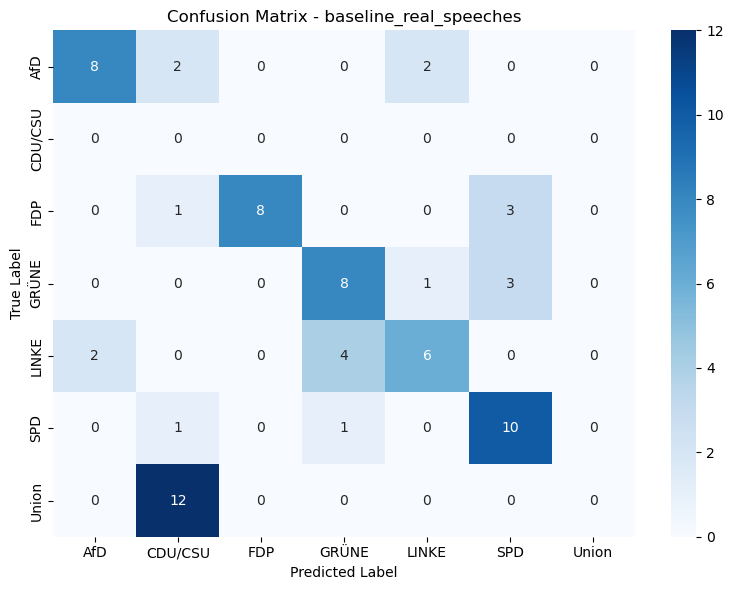

In [46]:
# run get_metrics function on all and save results 
final_performance_results = {}
i = 0

for i in range(len(model_names)):
    df = pd.DataFrame(all_results[model_names[i]])
    results =  get_metrics(df["label"], df["prediction_label"], model_names[i])
    final_performance_results.update(results)
    i += 1


In [47]:
final_performance_results

{'speech_base_model_01': {'acc': 0.08333333333333333,
  'bal_acc': 0.08333333333333333,
  'precision': 0.044444444444444446,
  'recall': 0.07142857142857142,
  'f1': 0.05372405372405372},
 'speech_ft_model_01': {'acc': 0.20833333333333334,
  'bal_acc': 0.20833333333333334,
  'precision': 0.1765873015873016,
  'recall': 0.20833333333333334,
  'f1': 0.17474747474747473},
 'speech_base_model_03': {'acc': 0.16666666666666666,
  'bal_acc': 0.16666666666666666,
  'precision': 0.2346938775510204,
  'recall': 0.14285714285714285,
  'f1': 0.13650793650793652},
 'speech_ft_model_03': {'acc': 0.16666666666666666,
  'bal_acc': 0.16666666666666666,
  'precision': 0.0695970695970696,
  'recall': 0.14285714285714285,
  'f1': 0.0907563025210084},
 'RAG_speech_01': {'acc': 0.08333333333333333,
  'bal_acc': 0.08333333333333333,
  'precision': 0.03333333333333333,
  'recall': 0.08333333333333333,
  'f1': 0.04761904761904762},
 'RAG_speech_03': {'acc': 0.20833333333333334,
  'bal_acc': 0.20833333333333334

In [48]:
# compare final results
final_performance_results_df = pd.DataFrame(final_performance_results)
final_performance_results_df

,speech_base_model_01,speech_ft_model_01,speech_base_model_03,speech_ft_model_03,RAG_speech_01,RAG_speech_03,baseline_real_speeches
acc,0.083333,0.208333,0.166667,0.166667,0.083333,0.208333,0.555556
bal_acc,0.083333,0.208333,0.166667,0.166667,0.083333,0.208333,0.555556
precision,0.044444,0.176587,0.234694,0.069597,0.033333,0.102778,0.529579
recall,0.071429,0.208333,0.142857,0.142857,0.083333,0.208333,0.476190
f1,0.053724,0.174747,0.136508,0.090756,0.047619,0.136508,0.493284
